<a href="https://colab.research.google.com/github/tanvirtaher32/Sarcasm-Detection/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input,Dense, Embedding, GRU, LSTM, Bidirectional, concatenate
from keras.layers import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
# from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:

data_1 = pd.read_json("/content/drive/MyDrive/testdata/Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json("/content/drive/MyDrive/testdata/Sarcasm_Headlines_Dataset_v2.json", lines=True)
data =  pd.concat([data_1, data_2])
data.head(15)

# data  = pd.read_csv("/content/drive/MyDrive/testdata/finalDataset1.csv")
# data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
5,https://www.huffingtonpost.com/entry/advancing...,advancing the world's women,0
6,https://www.huffingtonpost.com/entry/how-meat-...,the fascinating case for eating lab-grown meat,0
7,https://www.huffingtonpost.com/entry/boxed-col...,"this ceo will send your kids to school, if you...",0
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
9,https://www.huffingtonpost.com/entry/fridays-m...,friday's morning email: inside trump's presser...,0


In [ ]:
def clean_text(text):
    text = text.lower()

    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))

    ###########   for emoji subtraction
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text


In [ ]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

#### for showing cleaned text as output ####
    count=0
    for line in lines:
      if(count<10):
        line = clean_text(line)
        print(line)
      count=count+1

###### ends here #######

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # # remove puntuations
        # table = str.maketrans('', '', string.punctuation)
        # stripped = [w.translate(table) for w in tokens]
        # # remove non alphabetic characters
        # words = [word for word in stripped if word.isalpha()]
        # stop_words = set(stopwords.words("english"))
        # stop_words.discard("not")
        # # remove stop words
        # words = [w for w in words if not w in stop_words]
        # head_lines.append(words)
        head_lines.append(tokens)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:5]


former versace store clerk sues over secret black code for minority shoppers
the roseanne revival catches up to our thorny political mood for better and worse
mom starting to fear sons web series closest thing she will have to grandchild
boehner just wants wife to listen not come up with alternative debtreduction ideas
jk rowling wishes snape happy birthday in the most magical way
advancing the worlds women
the fascinating case for eating labgrown meat
this ceo will send your kids to school if you work for his company
top snake handler leaves sinking huckabee campaign
fridays morning email inside trumps presser for the ages


[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'over',
  'secret',
  'black',
  'code',
  'for',
  'minority',
  'shoppers'],
 ['the',
  'roseanne',
  'revival',
  'catches',
  'up',
  'to',
  'our',
  'thorny',
  'political',
  'mood',
  'for',
  'better',
  'and',
  'worse'],
 ['mom',
  'starting',
  'to',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'she',
  'will',
  'have',
  'to',
  'grandchild'],
 ['boehner',
  'just',
  'wants',
  'wife',
  'to',
  'listen',
  'not',
  'come',
  'up',
  'with',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk',
  'rowling',
  'wishes',
  'snape',
  'happy',
  'birthday',
  'in',
  'the',
  'most',
  'magical',
  'way']]

mom starting to fear sons web series closest thing she will have to grandchild
boehner just wants wife to listen not come up with alternative debtreduction ideas
top snake handler leaves sinking huckabee campaign
nuclear bomb detonates during rehearsal for spiderman musical
cosby lawyer asks why accusers didnt come forward to be smeared by legal team years ago
stock analysts confused frightened by boar market
courtroom sketch artist has clear manga influences
trump assures nation that decision for syrian airstrikes came after carefully considering all his passing whims
excon back behind bar
after careful consideration bush recommends oil drilling


(-0.5, 999.5, 499.5, -0.5)

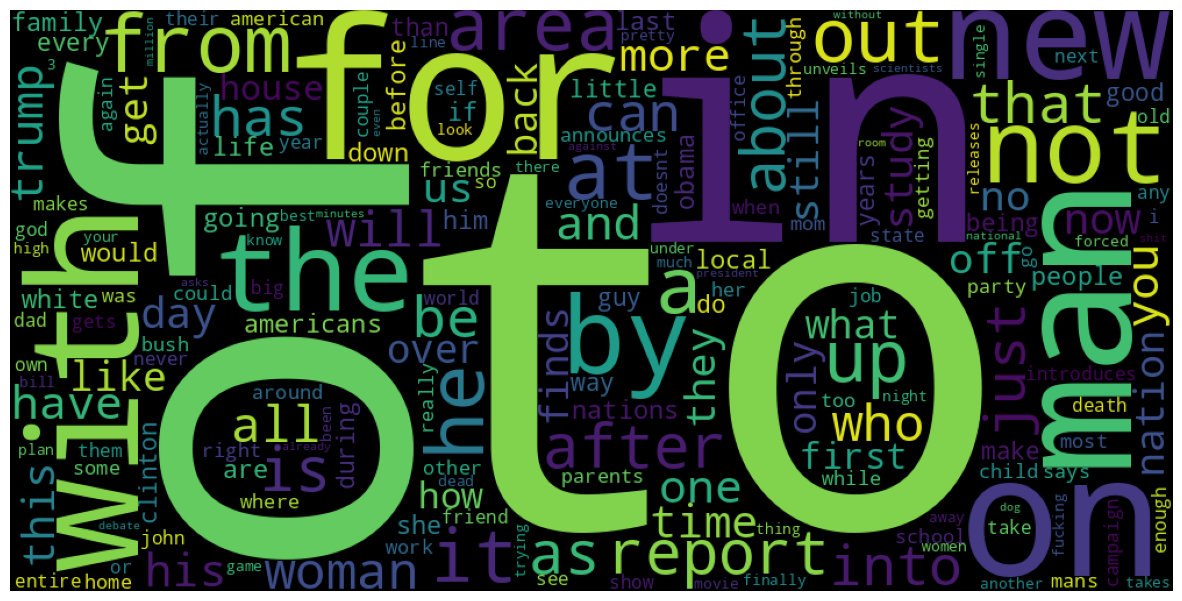

In [ ]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub]
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

**Train-test split**


In [ ]:
validation_split = 0.3
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  29753
vocab size - 29754


In [ ]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (38730, 25)
Shape of y_train: (38730,)
Shape of X_test_pad: (16598, 25)
Shape of y_test: (16598,)


**Glove**

In [ ]:
embeddings_index = {}
embedding_dim = 200
GLOVE_DIR = "/content/drive/MyDrive/testdata/"
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.200d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


**Build the embedding layer**

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

24899


**# Prepare POS tags**

In [ ]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def pos_tagging(text):
    sentences = sent_tokenize(text)
    pos_tags = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = [word for word in words if word.isalpha()]
        words = [word for word in words if not word in stop_words]
        pos_tags += nltk.pos_tag(words)
    return pos_tags

data['pos_tags'] = data['headline'].apply(pos_tagging)

**Extract POS tag features**

In [ ]:
def extract_pos_features(pos_tags):
    pos_features = []
    for tag in pos_tags:
        pos_features.append(tag[1])
    return pos_features

data['pos_features'] = data['pos_tags'].apply(extract_pos_features)

pos_tokenizer = Tokenizer()
pos_tokenizer.fit_on_texts(data['pos_features'])

pos_sequences = pos_tokenizer.texts_to_sequences(data['pos_features'])
pos_pad = pad_sequences(pos_sequences, maxlen=max_length, padding='post')

X_pos_pad = pos_pad[indices]

X_train_pos = X_pos_pad[:-num_validation_samples]
X_test_pos = X_pos_pad[-num_validation_samples:]

**Define the model architecture**

In [ ]:
text_input = Input(shape=(max_length,))
pos_input = Input(shape=(max_length,))

embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

text_embedded_sequences = embedding_layer(text_input)

**Build the RNN**

In [ ]:
# model = Sequential()
# model.add(embedding_layer)
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


lstm_layer = LSTM(64, dropout=0.2, recurrent_dropout=0.25)(text_embedded_sequences)

pos_embedded_sequences = Embedding(len(pos_tokenizer.word_index) + 1, embedding_dim, input_length=max_length, trainable=True)(pos_input)
lstm_pos = LSTM(64, dropout=0.2, recurrent_dropout=0.25)(pos_embedded_sequences)

concatenated = concatenate([lstm_layer, lstm_pos])

dense = Dense(1, activation='sigmoid')(concatenated)

model = Model(inputs=[text_input, pos_input], outputs=dense)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 200)      5950800     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 25, 200)      6600        ['input_2[0][0]']                
                                                                

**Training**

In [ ]:
# history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

history = model.fit([X_train_pad, X_train_pos], y_train, batch_size=32, epochs=25, validation_data=([X_test_pad, X_test_pos], y_test), verbose=2)

Epoch 1/25
1211/1211 - 76s - loss: 0.4208 - accuracy: 0.8056 - val_loss: 0.3294 - val_accuracy: 0.8533 - 76s/epoch - 63ms/step
Epoch 2/25
1211/1211 - 71s - loss: 0.3166 - accuracy: 0.8653 - val_loss: 0.2798 - val_accuracy: 0.8819 - 71s/epoch - 59ms/step
Epoch 3/25
1211/1211 - 71s - loss: 0.2705 - accuracy: 0.8879 - val_loss: 0.2608 - val_accuracy: 0.8940 - 71s/epoch - 58ms/step
Epoch 4/25
1211/1211 - 72s - loss: 0.2355 - accuracy: 0.9045 - val_loss: 0.2422 - val_accuracy: 0.8988 - 72s/epoch - 59ms/step
Epoch 5/25
1211/1211 - 72s - loss: 0.2071 - accuracy: 0.9184 - val_loss: 0.2085 - val_accuracy: 0.9161 - 72s/epoch - 59ms/step
Epoch 6/25
1211/1211 - 73s - loss: 0.1852 - accuracy: 0.9269 - val_loss: 0.2268 - val_accuracy: 0.9152 - 73s/epoch - 60ms/step
Epoch 7/25
1211/1211 - 72s - loss: 0.1655 - accuracy: 0.9344 - val_loss: 0.1891 - val_accuracy: 0.9249 - 72s/epoch - 60ms/step
Epoch 8/25
1211/1211 - 71s - loss: 0.1495 - accuracy: 0.9423 - val_loss: 0.1789 - val_accuracy: 0.9344 - 71s/ep

519/519 [==============================] - 6s 11ms/step
Confusion Matrix:
[[8817  291]
 [ 384 7106]]


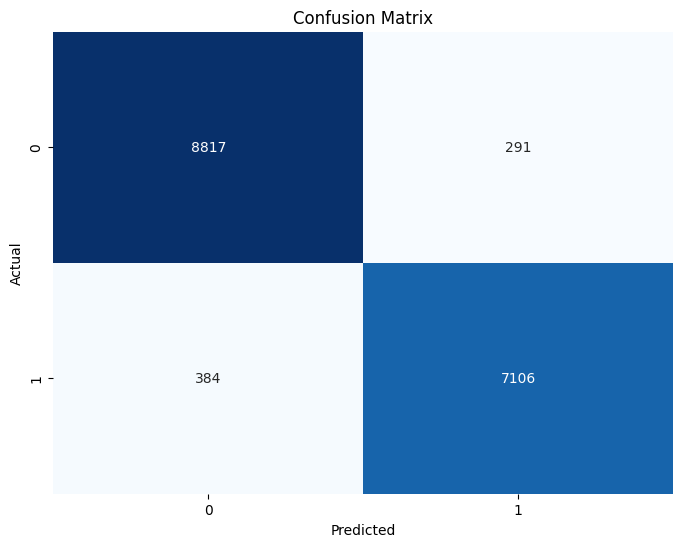

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      9108
           1       0.96      0.95      0.95      7490

    accuracy                           0.96     16598
   macro avg       0.96      0.96      0.96     16598
weighted avg       0.96      0.96      0.96     16598



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict the labels for the test set
y_pred = model.predict([X_test_pad, X_test_pos])
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate the classification report
class_report = classification_report(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:")
print(class_report)


**Visualize the learning**

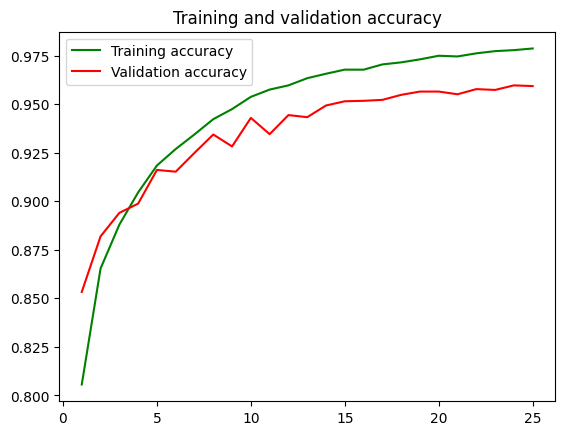

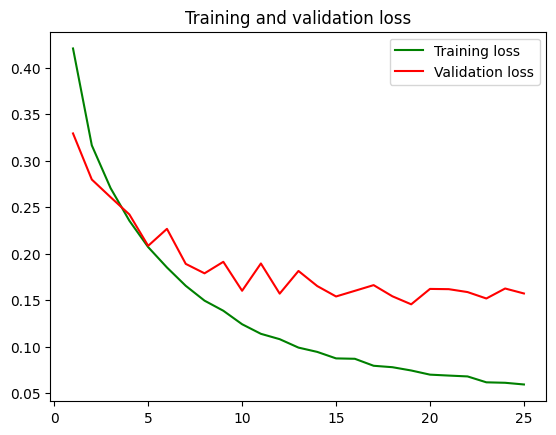

In [ ]:
# Plot results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()